# Modelo Random Forest

Após executar o EDA passa-se a elaboração do modelo Random Forest treinando-o com os mesmos dados já trabalhados. Seu objetivo elementar é ser uma ferramenta robusta que permita, considerando o grande número de dados, presentes em mais de 15 colunas, definir de forma confiável o carácter fraudulento dos endereços Ethereum, o que seria uma tarefa praticamente impossível sem o seu uso. A escolha do Random Forest justifica-se por se tratar de um algoritmo já consagrado e amplamente utilizado na construção de modelos de classificação. Foi empregado também, em seguida, o Índice de Gini, com o objetivo de medir a acurácia das predições e o algoritmo Shap que revela a relevância de cada variável na classificação feita pelo modelo.

In [28]:
import pandas as pd
import sqlite3
import shap
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_auc_score

In [2]:
con = sqlite3.connect("projetorisco.db") # Cria um banco de dados SQLite.

In [3]:
# Armazena o cursor.
cur = con.cursor()

In [4]:
df_geral = pd.read_sql_query("""
    SELECT *
    FROM transaction_dataset
""", con) # Cria um novo DataFrame e salva nele o resultado da consulta em SQL.

df_geral.head()

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,...,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [5]:
df_geral = df_geral.drop_duplicates()

In [6]:
# Seleciona as colunas numéricas, pois o modelo RandomForest trabalha melhor com variáveis numéricas.
df_geral_num = df_geral.select_dtypes(include = ['number'])

# Exibe as primeiras linhas do DataFrame resultante.
df_geral_num.head()

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,...,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0


In [7]:
colunas_selecionadas = ['FLAG', 'Time_Diff_between_first_and_last_(Mins)', 'total_ether_balance', 'Avg_min_between_sent_tnx',
 'Sent_tnx', 'total_Ether_sent', 'max_value_received', 'avg_val_received', 'total_ether_received', 'ERC20_uniq_rec_addr', 
 'ERC20_uniq_rec_contract_addr', 'ERC20_uniq_rec_token_name', 'Total_ERC20_tnxs', 'ERC20_avg_val_rec', 'ERC20_total_Ether_received', 
 'ERC20_min_val_rec', 'ERC20_max_val_rec'] # Define quais colunas considerar. Para tornar o treino do modelo mais objetivo, optou-se por considerar, 
                                           # do número total de colunas do DataFrame, apenas a metade mais significativa na definição de fraude, segundo o teste KS.

df_geral_num_main = df_geral_num[colunas_selecionadas] # Gera um novo DataFrame apenas com as colunas selecionadas.

df_geral_num_main.head()

,FLAG,Time_Diff_between_first_and_last_(Mins),total_ether_balance,Avg_min_between_sent_tnx,Sent_tnx,total_Ether_sent,max_value_received,avg_val_received,total_ether_received,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_uniq_rec_token_name,Total_ERC20_tnxs,ERC20_avg_val_rec,ERC20_total_Ether_received,ERC20_min_val_rec,ERC20_max_val_rec
0,0,704785.63,-279.224419,844.26,721,865.691093,45.806785,6.589513,586.466675,54.0,58.0,57.0,265.0,265586.147600,3.558854e+07,0.0,1.500000e+07
1,0,1218216.73,-0.001819,12709.07,94,3.087297,2.613269,0.385685,3.085478,5.0,7.0,7.0,8.0,57.632615,4.034283e+02,0.0,3.650000e+02
2,0,516729.30,0.000441,246194.54,2,3.588616,1.165453,0.358906,3.589057,7.0,8.0,8.0,8.0,65.189009,5.215121e+02,0.0,4.428198e+02
3,0,397555.90,-854.646303,10219.60,25,1750.045862,500.000000,99.488840,895.399559,11.0,11.0,11.0,14.0,1555.550174,1.711105e+04,0.0,1.141223e+04
4,0,382472.42,-50.896986,36.61,4598,104.318883,12.802411,2.671095,53.421897,23.0,27.0,27.0,42.0,4934.232147,1.628297e+05,0.0,9.000000e+04


In [8]:
coluna_transicao = {
    'FLAG': 'FLAG', 
    'Time_Diff_between_first_and_last_(Mins)': 'Dif_tempo_entre_primeira_ultima_trans',
    'total_ether_balance': 'Saldo_total_pos_trans_enviadas',
    'Avg_min_between_sent_tnx': 'Tempo_med_entre_trans_enviadas',
    'Sent_tnx': 'Total_trans_normais_enviadas',
    'total_Ether_sent': 'Total_ether_enviado',
    'max_value_received': 'Val_max_recebido',
    'avg_val_received': 'Val_med_recebido',
    'total_ether_received': 'Total_ether_recebido',
    'ERC20_uniq_rec_addr': 'N_trans_token_recebidas_end_exc',
    'ERC20_uniq_rec_contract_addr': 'N_trans_token_recebidas_end_contrato_exc',
    'ERC20_uniq_rec_token_name': 'N_tokens_exc_recebidos_trans_ERC20',
    'Total_ERC20_tnxs': 'N_trans_tokens_ERC20',
    'ERC20_avg_val_rec': 'Val_med_ether_recebido_trans_token_ERC20',
    'ERC20_total_Ether_received': 'Total_ether_recebido_trans_token_ERC20_',
    'ERC20_min_val_rec': 'Val_min_recebido_trans_token_ERC20',
    'ERC20_max_val_rec': 'Val_max_recebido_trans_token_ERC20'
} # Cria um dicionário em que key: nomeclatura em inglês e value: nomenclatura em português.

In [9]:
# Renomeia as colunas utilizando o dicionário coluna_transicao.
df_geral_num_main = df_geral_num_main.copy()
df_geral_num_main.rename(columns=coluna_transicao, inplace=True)

# Verifica as primeiras linhas do DataFrame para confirmar as alterações.
df_geral_num_main.head()

,FLAG,Dif_tempo_entre_primeira_ultima_trans,Saldo_total_pos_trans_enviadas,Tempo_med_entre_trans_enviadas,Total_trans_normais_enviadas,Total_ether_enviado,Val_max_recebido,Val_med_recebido,Total_ether_recebido,N_trans_token_recebidas_end_exc,N_trans_token_recebidas_end_contrato_exc,N_tokens_exc_recebidos_trans_ERC20,N_trans_tokens_ERC20,Val_med_ether_recebido_trans_token_ERC20,Total_ether_recebido_trans_token_ERC20_,Val_min_recebido_trans_token_ERC20,Val_max_recebido_trans_token_ERC20
0,0,704785.63,-279.224419,844.26,721,865.691093,45.806785,6.589513,586.466675,54.0,58.0,57.0,265.0,265586.147600,3.558854e+07,0.0,1.500000e+07
1,0,1218216.73,-0.001819,12709.07,94,3.087297,2.613269,0.385685,3.085478,5.0,7.0,7.0,8.0,57.632615,4.034283e+02,0.0,3.650000e+02
2,0,516729.30,0.000441,246194.54,2,3.588616,1.165453,0.358906,3.589057,7.0,8.0,8.0,8.0,65.189009,5.215121e+02,0.0,4.428198e+02
3,0,397555.90,-854.646303,10219.60,25,1750.045862,500.000000,99.488840,895.399559,11.0,11.0,11.0,14.0,1555.550174,1.711105e+04,0.0,1.141223e+04
4,0,382472.42,-50.896986,36.61,4598,104.318883,12.802411,2.671095,53.421897,23.0,27.0,27.0,42.0,4934.232147,1.628297e+05,0.0,9.000000e+04


In [10]:
# Separa as variáveis independentes (X) e a variável dependente (y).
X = df_geral_num_main.drop(['FLAG'], axis=1) # Remove as colunas 'Address' e 'FLAG'.
y = df_geral_num_main['FLAG'] # Variável alvo (target).

In [11]:
features = list(X.columns)

In [12]:
X.info() # Traz o formato dos dados.

<class 'pandas.core.frame.DataFrame'>
Index: 9823 entries, 0 to 9840
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Dif_tempo_entre_primeira_ultima_trans     9823 non-null   float64
 1   Saldo_total_pos_trans_enviadas            9823 non-null   float64
 2   Tempo_med_entre_trans_enviadas            9823 non-null   float64
 3   Total_trans_normais_enviadas              9823 non-null   int64  
 4   Total_ether_enviado                       9823 non-null   float64
 5   Val_max_recebido                          9823 non-null   float64
 6   Val_med_recebido                          9823 non-null   float64
 7   Total_ether_recebido                      9823 non-null   float64
 8   N_trans_token_recebidas_end_exc           8994 non-null   float64
 9   N_trans_token_recebidas_end_contrato_exc  8994 non-null   float64
 10  N_tokens_exc_recebidos_trans_ERC20       

In [13]:
X[features] = X[features].astype(float) # Converte as variáveis independentes em float.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) # Define o tamanho da amostra teste.

In [15]:
# Cria o modelo do tipo Random Forest.
rf_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Treina o modelo.
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

A escolha pela criação de um modelo Random Forest justifica-se por sua resiliência ao acréscimo de novos dados ao DataFrame e seu sistema de criação múltipla de árvores de decisão.

In [16]:
# Obtém as probabilidades de cada classe (probabilidade da classe positiva, geralmente classe '1').
y_prob = rf_model.predict_proba(X_test)[:, 1] # [:, 1] pega a probabilidade da classe '1' (fraude).

In [17]:
# Calcula o AUC-ROC.
auc_roc = roc_auc_score(y_test, y_prob)

# Calcula o Gini Index.
gini = 2 * auc_roc - 1

# Exibe os valores.
print(f'ROC AUC: {auc_roc:.4f}')
print(f'Índice de Gini: {gini:.4f}')

ROC AUC: 0.9905
Índice de Gini: 0.9810


In [18]:
df_geral_num_main.loc[:, 'Probabilidade_Fraude'] = rf_model.predict_proba(X)[:, 1]
                                                                       # Cria uma nova coluna no DataFrame df_geral_num 
                                                                       # com a probabilidade de fraude de cada endenreço.

In [19]:
df_geral_num_main.head(10)

,FLAG,Dif_tempo_entre_primeira_ultima_trans,Saldo_total_pos_trans_enviadas,Tempo_med_entre_trans_enviadas,Total_trans_normais_enviadas,Total_ether_enviado,Val_max_recebido,Val_med_recebido,Total_ether_recebido,N_trans_token_recebidas_end_exc,N_trans_token_recebidas_end_contrato_exc,N_tokens_exc_recebidos_trans_ERC20,N_trans_tokens_ERC20,Val_med_ether_recebido_trans_token_ERC20,Total_ether_recebido_trans_token_ERC20_,Val_min_recebido_trans_token_ERC20,Val_max_recebido_trans_token_ERC20,Probabilidade_Fraude
0,0,704785.63,-279.224419,844.26,721,865.691093,45.806785,6.589513,586.466675,54.0,58.0,57.0,265.0,265586.147600,3.558854e+07,0.0,1.500000e+07,0.0
1,0,1218216.73,-0.001819,12709.07,94,3.087297,2.613269,0.385685,3.085478,5.0,7.0,7.0,8.0,57.632615,4.034283e+02,0.0,3.650000e+02,0.0
2,0,516729.30,0.000441,246194.54,2,3.588616,1.165453,0.358906,3.589057,7.0,8.0,8.0,8.0,65.189009,5.215121e+02,0.0,4.428198e+02,0.0
3,0,397555.90,-854.646303,10219.60,25,1750.045862,500.000000,99.488840,895.399559,11.0,11.0,11.0,14.0,1555.550174,1.711105e+04,0.0,1.141223e+04,0.0
4,0,382472.42,-50.896986,36.61,4598,104.318883,12.802411,2.671095,53.421897,23.0,27.0,27.0,42.0,4934.232147,1.628297e+05,0.0,9.000000e+04,0.0
5,0,20926.68,0.001008,9900.12,2,9.703716,4.813776,3.234908,9.704724,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0
6,0,8660.35,0.016872,69.46,25,12.062394,2.650000,1.098115,12.079266,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0
7,0,319828.05,-4.247902,1497.39,213,8.703392,2.000000,0.891098,4.455490,5.0,7.0,7.0,7.0,56.850281,3.979520e+02,0.0,3.650000e+02,0.0
8,0,496.62,0.000620,0.00,1,1.999380,2.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.0
9,0,30572.70,-98.977000,2570.59,8,149.077000,40.000000,16.700000,50.100000,1.0,1.0,1.0,1.0,600.000000,6.000000e+02,600.0,6.000000e+02,0.0


In [20]:
explainer = shap.Explainer(rf_model.predict, X_test) # Aplica o algoritmo Shap ao modelo.
shap_values = explainer(X_test)

PermutationExplainer explainer: 2948it [09:21,  5.18it/s]                                                              


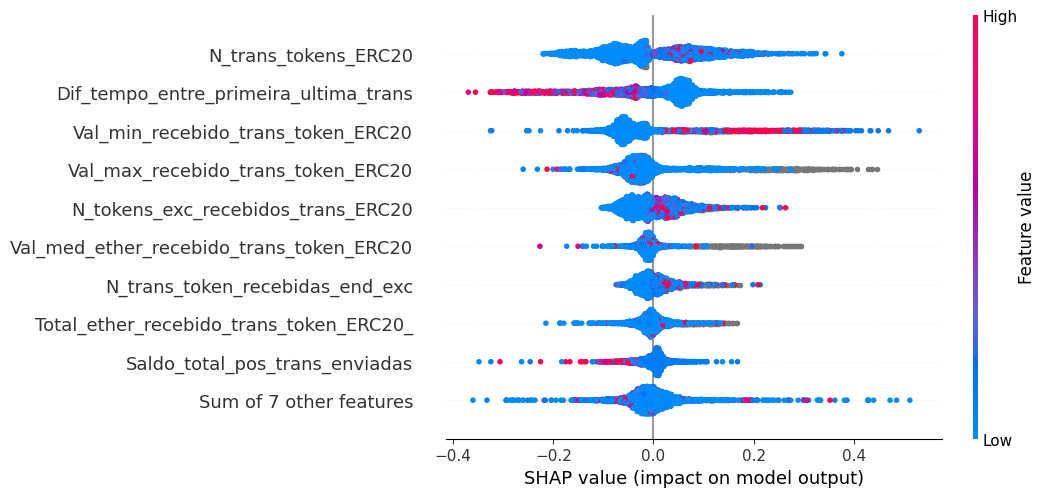

In [21]:
shap.plots.beeswarm(shap_values) # Cria o gráfico com o valor Shap e o gradiente de magnitude das variáveis.

Após submeter o modelo Random Forest ao algoritmo Shap, obteve-se o gráfico acima cujos resultados indicam a importância de cada variável na definição de fraude. De acordo com o algoritmo, as 5 variáveis mais importantes são:
1.N_trans_tokens_ERC20, que representa o número de transações, com transferência de token ERC20, realizadas:
 O gráfico indica que, para esta variável, em linhas gerais, quando maior o número de destas transações, maior a probabilidade de que a carteira correspondente seja fraudulenta.

2.Dif_tempo_entre_primeira_ultima_trans, que aponta a diferença de tempo entre a primeira e a última transação;
 Quando a esta, é possível notar, claramente, que quanto maior o intervalo de tempo entre transações, menor a probabilidade de fraude.
 
3.Val_min_recebido_trans_token_ERC20, apresentando os valores mínimos recebidos, em ethers, a partir de transações com envio de token ERC20;
 A variável em questão, por sua vez, apresenta um comportamento inverso ao da variável anterior. É possível notar com clareza que, quanto maior o valor mínimo recebido, maior a a probabilidade de fraude. Logo, retomando as informações obtidas no EDA e comparando-as com os resultados atuais, constata-se que são coincidentes e apontam para a mesma conclusão.

4.Val_max_recebido_trans_token_ERC20, apresentando os valores máximos recebidos, em ethers, a partir de transações com envio de token ERC20;
 Diferente das demais variáveis, os valores com maior probabilidade de fraude, neste caso, são os valores nulos. Logo, quanto maior a concentração de nulos, maior é a probabilidade de fraude. No entanto, ao longo dos valores Shap positivos, existem, também, muito valores considerados baixos pelo algoritmo e isso, combinado aos resultados da divisão por decis, corrobora com a afirmação de que valores baixos possuem maior chance de serem fraude;
 
5.N_tokens_exc_recebidos_trans_ERC20, cujo função é indicar o número de tokens diferentes recebidos a partir de transações com envio de token ERC20.
 A quinta variável mais significativa, de acordo com o Shap, apresenta, entre os valores classificados como altos, as maiores probabilidades de fraude.

In [22]:
df_geral_num_main['Probabilidade_Fraude'] = df_geral_num_main['Probabilidade_Fraude'] * 1000

In [23]:
# Define os decis dos valores considerando apenas observações em que 'Probabilidade_Fraude'.
for col in df_geral_num_main.select_dtypes(include='number').columns:
    col_decis = f'{col}_decis'
    df_geral_num_main[col_decis] = pd.qcut(df_geral_num_main[col], 
                                           q=10, labels=False, duplicates='drop') + 1

In [24]:
df_geral_num_main.head(10)

,FLAG,Dif_tempo_entre_primeira_ultima_trans,Saldo_total_pos_trans_enviadas,Tempo_med_entre_trans_enviadas,Total_trans_normais_enviadas,Total_ether_enviado,Val_max_recebido,Val_med_recebido,Total_ether_recebido,N_trans_token_recebidas_end_exc,...,Total_ether_recebido_decis,N_trans_token_recebidas_end_exc_decis,N_trans_token_recebidas_end_contrato_exc_decis,N_tokens_exc_recebidos_trans_ERC20_decis,N_trans_tokens_ERC20_decis,Val_med_ether_recebido_trans_token_ERC20_decis,Total_ether_recebido_trans_token_ERC20__decis,Val_min_recebido_trans_token_ERC20_decis,Val_max_recebido_trans_token_ERC20_decis,Probabilidade_Fraude_decis
0,0,704785.63,-279.224419,844.26,721,865.691093,45.806785,6.589513,586.466675,54.0,...,9,5.0,5.0,5.0,5.0,5.0,6.0,1.0,5.0,1
1,0,1218216.73,-0.001819,12709.07,94,3.087297,2.613269,0.385685,3.085478,5.0,...,3,4.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,1
2,0,516729.30,0.000441,246194.54,2,3.588616,1.165453,0.358906,3.589057,7.0,...,3,4.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,1
3,0,397555.90,-854.646303,10219.60,25,1750.045862,500.000000,99.488840,895.399559,11.0,...,10,5.0,4.0,4.0,4.0,4.0,5.0,1.0,4.0,1
4,0,382472.42,-50.896986,36.61,4598,104.318883,12.802411,2.671095,53.421897,23.0,...,6,5.0,5.0,5.0,5.0,5.0,6.0,1.0,5.0,1
5,0,20926.68,0.001008,9900.12,2,9.703716,4.813776,3.234908,9.704724,0.0,...,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,0,8660.35,0.016872,69.46,25,12.062394,2.650000,1.098115,12.079266,0.0,...,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
7,0,319828.05,-4.247902,1497.39,213,8.703392,2.000000,0.891098,4.455490,5.0,...,3,4.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,1
8,0,496.62,0.000620,0.00,1,1.999380,2.000000,2.000000,2.000000,0.0,...,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,0,30572.70,-98.977000,2570.59,8,149.077000,40.000000,16.700000,50.100000,1.0,...,6,1.0,1.0,1.0,1.0,4.0,5.0,3.0,4.0,1


In [25]:
# Cria um novo DataFrame apenas com as colunas de interesse de df_geral_num_main.
df_geral_num_f1 = df_geral_num_main[['FLAG', 'Probabilidade_Fraude', 'Probabilidade_Fraude_decis']]

df_geral_num_f1.head()

,FLAG,Probabilidade_Fraude,Probabilidade_Fraude_decis
0,0,0.0,1
1,0,0.0,1
2,0,0.0,1
3,0,0.0,1
4,0,0.0,1


In [33]:
df_geral_num_f1_resumo = df_geral_num_f1.groupby('Probabilidade_Fraude_decis').agg(
    Total_Registros = ('FLAG', 'count'),
    Total_Registros_Flag_1 = ('FLAG', 'sum'),
    Flag_1_Percentual = ('FLAG', 'mean'),
    Min_Valor = ('Probabilidade_Fraude', 'min'), # Menor valor no decil.
    Max_Valor = ('Probabilidade_Fraude', 'max')  # Maior valor no decil.
)# Como 'FLAG' é 0 ou 1, a média já representa a proporção

# Converte a porcentagem corretamente.
df_geral_num_f1_resumo['Flag_1_Percentual'] *= 100 # Calcula a probabilidade de encontrar uma observação com 'FLAG' = 1.

# Exibe o dataframe de resumo.
df_geral_num_f1_resumo.head(10)

,Total_Registros,Total_Registros_Flag_1,Flag_1_Percentual,Min_Valor,Max_Valor
Probabilidade_Fraude_decis,,,,,
1,7921,278,3.509658,0.0,800.0
2,1902,1901,99.947424,900.0,1000.0


Por fim, após dividir a coluna 'Probabilidade_Fraude' em decis, com o objetivo de verificar qual intervalo de probabilidades mais apresentaria carteiras fraudulentas, contata-se que o modelo conseguiu, como seu valor de Gini já indica, atingir um nível bastante satisfatório quanto a separação de carteiras fraudulentas e não fraudulentas. Dessa forma, quando da aplicação deste modelo em um novo conjunto de dados, após proceder a divisão for decis, como feito acima, a melhor estratégia é focar ações de combate à fraude nas carteiras selecionadas no decil 2, pois a probabilidade de que, de fato, trata-se de um endereço fraudulentos é bastante alta.